## Predicting Sentiments around the College Football Playoffs
1. Likelihood of each team winning – positive, neutral, negative and by what ratio
2. Find keywords/clusters of what each team is associated with
3. Compare pre-game vs post-game sentiment shifts

Additional Extension: Does Twitter sentiment lead or lag expert opinion? – Conduct correlation tests

On Point 2, 
Use LDA or BERTopic to extract themes:
- Offense / defense / coaching
- Injuries
- CFP committee bias
- SEC Bias
- Strength of schedule

In [ ]:
!brew install pandas numpy datetime tweepy

In [ ]:
%pip install tweety-ns

## Step 1: Collecting Data on Game Victories

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Teams with their playoff journey
teams = {
    "Georgia": {"rank": 2, "region": "SEC", "result": "eliminated_semifinals"},
    "Notre Dame": {"rank": 7, "region": "Independent", "result": "runner_up"},
    "Ohio State": {"rank": 8, "region": "Big Ten", "result": "champion"},
    "Clemson": {"rank": 12, "region": "ACC", "result": "eliminated_first_round"},
    "Texas": {"rank": 5, "region": "SEC", "result": "eliminated_semifinals"},
    "Arizona State": {"rank": 4, "region": "Big 12", "result": "eliminated_quarterfinals"},
    "Tennessee": {"rank": 9, "region": "SEC", "result": "eliminated_first_round"},
    "Oregon": {"rank": 1, "region": "Big Ten", "result": "eliminated_quarterfinals"},
    "SMU": {"rank": 11, "region": "ACC", "result": "eliminated_first_round"},
    "Penn State": {"rank": 6, "region": "Big Ten", "result": "eliminated_semifinals"},
    "Boise State": {"rank": 3, "region": "Mountain West", "result": "eliminated_quarterfinals"},
    "Indiana": {"rank": 10, "region": "Big Ten", "result": "eliminated_first_round"},
}

games = [
    # First Round - December 20-21
    {
        "round": "first_round",
        "date": datetime(2024, 12, 20, 20, 0),
        "matchup": "Indiana vs Notre Dame",
        "winner": "Notre Dame",
        "loser": "Indiana",
        "score": "Notre Dame 27, Indiana 17"
    },
    {
        "round": "first_round",
        "date": datetime(2024, 12, 21, 12, 0),
        "matchup": "SMU vs Penn State",
        "winner": "Penn State",
        "loser": "SMU",
        "score": "Penn State 38, SMU 10"
    },
    {
        "round": "first_round",
        "date": datetime(2024, 12, 21, 16, 0),
        "matchup": "Clemson vs Texas",
        "winner": "Texas",
        "loser": "Clemson",
        "score": "Texas 38, Clemson 24"
    },
    {
        "round": "first_round",
        "date": datetime(2024, 12, 21, 20, 0),
        "matchup": "Tennessee vs Ohio State",
        "winner": "Ohio State",
        "loser": "Tennessee",
        "score": "Ohio State 42, Tennessee 17"
    },
    # Quarterfinals - December 31 - January 2
    {
        "round": "quarterfinals",
        "date": datetime(2024, 12, 31, 19, 30),
        "matchup": "Penn State vs Boise State",
        "winner": "Penn State",
        "loser": "Boise State",
        "score": "Penn State 31, Boise State 14"
    },
    {
        "round": "quarterfinals",
        "date": datetime(2025, 1, 1, 13, 0),
        "matchup": "Texas vs Arizona State",
        "winner": "Texas",
        "loser": "Arizona State",
        "score": "Texas 39, Arizona State 31 (2OT)"
    },
    {
        "round": "quarterfinals",
        "date": datetime(2025, 1, 1, 17, 0),
        "matchup": "Ohio State vs Oregon",
        "winner": "Ohio State",
        "loser": "Oregon",
        "score": "Ohio State 41, Oregon 21"
    },
    {
        "round": "quarterfinals",
        "date": datetime(2025, 1, 2, 16, 0),
        "matchup": "Notre Dame vs Georgia",
        "winner": "Notre Dame",
        "loser": "Georgia",
        "score": "Notre Dame 23, Georgia 10"
    },
    # Semifinals - January 9-10
    {
        "round": "semifinals",
        "date": datetime(2025, 1, 9, 19, 30),
        "matchup": "Notre Dame vs Penn State",
        "winner": "Notre Dame",
        "loser": "Penn State",
        "score": "Notre Dame 27, Penn State 24"
    },
    {
        "round": "semifinals",
        "date": datetime(2025, 1, 10, 19, 30),
        "matchup": "Ohio State vs Texas",
        "winner": "Ohio State",
        "loser": "Texas",
        "score": "Ohio State 28, Texas 14"
    },
    # Championship - January 20
    {
        "round": "championship",
        "date": datetime(2025, 1, 20, 19, 30),
        "matchup": "Ohio State vs Notre Dame",
        "winner": "Ohio State",
        "loser": "Notre Dame",
        "score": "Ohio State 34, Notre Dame 23"
    },
]

# Create a mapping of team -> their games
team_games = {}
for team in teams.keys():
    team_games[team] = []
    for game in games:
        if team in game["matchup"]:
            is_winner = (team == game["winner"])
            team_games[team].append({
                **game,
                "team_won": is_winner,
                "opponent": game["winner"] if not is_winner else game["loser"]
            })

## Step 2: Generating Tweets

Note: Twitter's API Tweety was not working very well, so for the sake of testing. I am simulating this

In [9]:
# Tweet templates
tweet_templates = {
    'offense': {
        'positive': [
            "{team}'s offense is absolutely explosive! Best in the nation #CFP",
            "The {team} offense is unstoppable right now. Championship caliber!",
            "{team} putting up 40+ points like it's nothing 🔥",
            "QB play from {team} is elite. Heisman level performance",
            "{team}'s rushing attack is dominating everyone",
        ],
        'negative': [
            "{team}'s offense struggled against good defenses",
            "Too many turnovers from {team}'s offense this season",
            "{team} can't move the ball when it matters most",
            "Offensive line for {team} is a major weakness",
            "{team}'s QB makes too many mistakes under pressure",
        ]
    },
    'defense': {
        'positive': [
            "{team} defense is shutting everyone down! Elite unit 💪",
            "Best defensive line in college football belongs to {team}",
            "{team}'s secondary is lockdown. Can't throw on them",
            "Holding opponents to under 10 points. {team} defense is insane",
            "{team} has the most dominant defense I've seen in years",
        ],
        'negative': [
            "{team}'s defense gets gashed by the run game",
            "Secondary for {team} is vulnerable to deep passes",
            "{team} can't stop the opposing offense when it matters",
            "Defense is {team}'s biggest weakness heading into playoffs",
            "{team} got exposed on defense in their last game",
        ]
    },
    'coaching': {
        'positive': [
            "{team}'s coaching staff is making all the right calls",
            "Best game plan I've seen. {team} coaches are brilliant",
            "{team} coach is a genius. Best in the business",
            "In-game adjustments by {team} coaching staff were perfect",
            "{team} is so well-coached. Always prepared",
        ],
        'negative': [
            "{team}'s coaching decisions cost them that game",
            "Questionable play calling from {team} all season",
            "{team} coach is in over his head in big games",
            "Terrible clock management by {team} coaching staff",
            "{team} keeps making the same coaching mistakes",
        ]
    },
    'injuries': {
        'positive': [
            "{team} getting healthy at the right time 🙏",
            "Key players returning for {team} just in time for playoffs",
            "{team} depth is impressive. Next man up mentality",
        ],
        'negative': [
            "Devastating injury news for {team}. Their best player is out",
            "{team} can't catch a break with injuries this season",
            "Without their star player, {team} has no chance",
            "{team} injury report is concerning heading into playoffs",
        ]
    },
    'committee_bias': {
        'positive': [
            "Committee got it right. {team} earned their spot",
            "{team} deserves to be in the playoff. No question",
            "Resume speaks for itself. {team} belongs here",
        ],
        'negative': [
            "Committee bias toward {team} is ridiculous",
            "{team} doesn't deserve to be ranked this high",
            "They're only in because of their name. {team} is overrated",
            "Conference bias helping {team} get in the playoff",
        ]
    },
    'sec_bias': {
        'negative': [
            "SEC bias is why {team} is ranked so high. Ridiculous",
            "{team} played nobody and got rewarded for it. SEC privilege",
            "If {team} was in any other conference they'd be ranked 15th",
        ]
    },
    'strength_of_schedule': {
        'positive': [
            "{team} played the toughest schedule in the country",
            "Strength of schedule for {team} is elite. Battle tested",
            "{team} earned this. They beat quality opponents all year",
        ],
        'negative': [
            "{team} played a weak schedule and everyone knows it",
            "Cupcake schedule for {team}. Haven't played anyone good",
            "{team} got lucky with their schedule this year",
        ]
    },
    'neutral': [
        "Watching {team} play today",
        "{team} game starts soon",
        "Kickoff time for {team} matchup announced",
        "Breaking: {team} depth chart released",
        "{team} vs {opponent} preview",
        "Stats for {team} this season",
    ]
}

# Generate tweets with game-aware context
tweets_list = []
start_date = datetime(2024, 12, 1)
end_date = datetime(2025, 1, 21)

for team, info in teams.items():
    team_game_list = team_games.get(team, [])
    num_tweets = random.randint(800, 1200)
    
    for i in range(num_tweets):
        # Random timestamp across the entire playoff period
        days_diff = (end_date - start_date).days
        random_offset = random.randint(0, days_diff * 24 * 60)
        tweet_date = start_date + timedelta(minutes=random_offset)
        
        game_context = "pre-playoff"
        current_game = None
        hours_to_game = None
        
        for game in team_game_list:
            hours_diff = (tweet_date - game["date"]).total_seconds() / 3600
            if -72 <= hours_diff <= 48:
                current_game = game
                hours_to_game = -hours_diff # -ve = before the game
                if hours_to_game > 72:
                    game_context = f"pre_{game['round']}_early"
                elif hours_to_game > 0:
                    game_context = f"pre_{game['round']}_close"
                elif hours_to_game >= -6:
                    game_context = f"live_{game['round']}"
                else:
                    game_context = f"post_{game['round']}"
                break
        rand = random.random()
        if rand < 0.20:
            theme = 'neutral'
            if current_game and 'opponent' in current_game:
                text = f"Watching {team} play today"
                if random.random() > 0.5:
                    text = f"{team} vs {current_game['opponent']} {game_context.split('_')[1]} game"
            else:
                text = random.choice(tweet_templates['neutral']).format(team=team, opponent="their opponent")
            sentiment_type = 'neutral'
        
        else:
            theme = random.choice(['offense', 'defense', 'coaching', 'injuries', 
                                   'committee_bias', 'strength_of_schedule'])
            # SEC bias
            if info['region'] == 'SEC' and random.random() < 0.15:
                theme = 'sec_bias'
            base_positive_prob = 0.6
            if current_game:
                if game_context.startswith('post_'):
                    if current_game['team_won']:
                        base_positive_prob = 0.85  # Much more positive after win
                    else:
                        base_positive_prob = 0.20  # Much more negative after loss
                elif game_context.startswith('live_'):
                    base_positive_prob = 0.50
            
            # Determine sentiment
            if theme == 'sec_bias':
                sentiment_type = 'negative'
                text = random.choice(tweet_templates[theme]['negative']).format(team=team)
            else:
                if random.random() < base_positive_prob:
                    sentiment_type = 'positive'
                    text = random.choice(tweet_templates[theme]['positive']).format(team=team)
                else:
                    sentiment_type = 'negative'
                    text = random.choice(tweet_templates[theme]['negative']).format(team=team)
        
        if current_game and random.random() > 0.7:
            if game_context.startswith('post_') and current_game['team_won']:
                text += f" What a win over {current_game['opponent']}!"
            elif game_context.startswith('post_') and not current_game['team_won']:
                text += f" Tough loss to {current_game['opponent']}"
            elif game_context.startswith('pre_'):
                text += f" Ready for {current_game['opponent']}!"
        # Add hashtags
        if random.random() > 0.6:
            round_hashtag = f"#{current_game['round'].title().replace('_', '')}" if current_game else "#CFP"
            text += " " + random.choice(["#CFP", "#CollegeFootball", round_hashtag, f"#{team.replace(' ', '')}"])
        
        tweets_list.append({
            'date': tweet_date,
            'tweet_id': f"{team[:3].upper()}{i:04d}",
            'text': text,
            'user': f"cfb_fan_{random.randint(1000, 99999)}",
            'followers': int(np.random.lognormal(7, 2)),
            'likes': int(np.random.lognormal(2, 2)),
            'retweets': int(np.random.lognormal(1, 1.5)),
            'replies': int(np.random.lognormal(0.5, 1.5)),
            'team_searched': team,
            'actual_sentiment': sentiment_type,
            'theme': theme,
            'game_context': game_context,
            'team_rank': info['rank'],
            'team_region': info['region'],
            'current_round': current_game['round'] if current_game else None,
            'opponent': current_game['opponent'] if current_game else None,
            'game_result': 'won' if (current_game and current_game['team_won']) else ('lost' if current_game else None)
        })

# Convert to DataFrame
df = pd.DataFrame(tweets_list)
df = df.sort_values('date').reset_index(drop=True)
print(f"\nSentiment distribution:")
print(df['actual_sentiment'].value_counts())
print(f"\nGame context distribution:")
print(df['game_context'].value_counts().head(15))
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")

# Save
df.to_csv('cfp_tweets_full_playoff.csv', index=False)
df.to_pickle('cfp_tweets_full_playoff.pkl')


Sentiment distribution:
actual_sentiment
positive    5428
negative    4041
neutral     2368
Name: count, dtype: int64

Game context distribution:
game_context
pre-playoff                9750
pre_first_round_close       479
pre_quarterfinals_close     407
post_quarterfinals          283
post_first_round            272
pre_semifinals_close        263
post_semifinals             137
pre_championship_close      118
live_first_round             47
live_quarterfinals           44
live_semifinals              29
live_championship             8
Name: count, dtype: int64

Date range: 2024-12-01 00:04:00 to 2025-01-21 00:00:00


## Data Overview/Sampling

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data
df = pd.read_pickle('cfp_tweets_full_playoff.pkl')

print("DATASET OVERVIEW")
print(f"\nShape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Total tweets: {len(df):,}")
print(f"Unique teams: {df['team_searched'].nunique()}")
print(f"Unique users: {df['user'].nunique()}")

# First few rows
print("SAMPLE DATA:")
display(df.head(10))

DATASET OVERVIEW

Shape: (11837, 17)
Columns: ['date', 'tweet_id', 'text', 'user', 'followers', 'likes', 'retweets', 'replies', 'team_searched', 'actual_sentiment', 'theme', 'game_context', 'team_rank', 'team_region', 'current_round', 'opponent', 'game_result']

Date range: 2024-12-01 00:04:00 to 2025-01-21 00:00:00
Total tweets: 11,837
Unique teams: 12
Unique users: 11135
SAMPLE DATA:


,date,tweet_id,text,user,followers,likes,retweets,replies,team_searched,actual_sentiment,theme,game_context,team_rank,team_region,current_round,opponent,game_result
0,2024-12-01 00:04:00,NOT0333,Watching Notre Dame play today,cfb_fan_33401,2245,0,0,0,Notre Dame,neutral,neutral,pre-playoff,7,Independent,None,None,None
1,2024-12-01 00:07:00,CLE0697,Clemson injury report is concerning heading in...,cfb_fan_86314,1133,43,30,0,Clemson,negative,injuries,pre-playoff,12,ACC,None,None,None
2,2024-12-01 00:11:00,CLE0050,Key players returning for Clemson just in time...,cfb_fan_17865,1396,2,11,0,Clemson,positive,injuries,pre-playoff,12,ACC,None,None,None
3,2024-12-01 00:12:00,ARI0409,Resume speaks for itself. Arizona State belong...,cfb_fan_62694,199,4,3,1,Arizona State,positive,committee_bias,pre-playoff,4,Big 12,None,None,None
4,2024-12-01 00:13:00,SMU0662,Defense is SMU's biggest weakness heading into...,cfb_fan_87204,431,3,12,7,SMU,negative,defense,pre-playoff,11,ACC,None,None,None
5,2024-12-01 00:22:00,GEO0506,Georgia doesn't deserve to be ranked this high...,cfb_fan_45676,2,10,40,10,Georgia,negative,committee_bias,pre-playoff,2,SEC,None,None,None
6,2024-12-01 00:35:00,NOT0845,Committee got it right. Notre Dame earned thei...,cfb_fan_40773,3529,4,3,8,Notre Dame,positive,committee_bias,pre-playoff,7,Independent,None,None,None
7,2024-12-01 01:24:00,NOT0318,Notre Dame game starts soon,cfb_fan_38128,93,1,5,38,Notre Dame,neutral,neutral,pre-playoff,7,Independent,None,None,None
8,2024-12-01 01:28:00,CLE0498,Clemson deserves to be in the playoff. No ques...,cfb_fan_14916,274,23,11,10,Clemson,positive,committee_bias,pre-playoff,12,ACC,None,None,None
9,2024-12-01 01:30:00,TEX0290,Texas deserves to be in the playoff. No question,cfb_fan_37202,219,287,70,0,Texas,positive,committee_bias,pre-playoff,5,SEC,None,None,None


## Step 4: Data Cleaning
This does not apply in this case since we manually generated the tweets

In [ ]:
"""
import re

def clean_tweet(text):
    """Clean tweet text"""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (keep the word)
    text = re.sub(r'#', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Apply cleaning
df['text_clean'] = df['text'].apply(clean_tweet)

# Remove duplicates
df_original_length = len(df)
df = df.drop_duplicates(subset=['text_clean'])
print(f"Removed {df_original_length - len(df)} duplicate tweets")

"""

## Step 5: Time Analysis

In [13]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()
df['date_only'] = df['date'].dt.date

def detailed_game_timing(row):
    if pd.isna(row['current_round']):
        return 'no_game'
    
    context = row['game_context']
    
    if 'pre_' in context:
        if 'early' in context:
            return 'pre_game_3days'
        else:
            return 'pre_game_24hrs'
    elif 'live_' in context:
        return 'during_game'
    elif 'post_' in context:
        return 'post_game_24hrs'
    else:
        return 'other'

df['game_timing'] = df.apply(detailed_game_timing, axis=1)

print(f"\nTweets by hour of day:")
print(df['hour'].value_counts().sort_index())
print(f"\nTweets by day of week:")
print(df['day_of_week'].value_counts())
print(f"\nTweets by game timing:")
print(df['game_timing'].value_counts())


Tweets by hour of day:
hour
0     158
1     123
2     131
3     113
4     126
5     132
6     141
7     136
8     116
9     124
10    121
11    129
12    121
13    113
14    115
15    131
16    132
17    129
18    117
19    124
20    139
21    124
22    140
23    133
Name: count, dtype: int64

Tweets by day of week:
day_of_week
Sunday       527
Monday       515
Thursday     448
Wednesday    430
Tuesday      422
Friday       376
Saturday     350
Name: count, dtype: int64

Tweets by game timing:
game_timing
no_game            2173
pre_game_24hrs      567
post_game_24hrs     297
during_game          31
Name: count, dtype: int64


## Step 6: Engagement and Outliers

In [14]:
print(df[['likes', 'retweets', 'replies', 'followers']].describe())

# Identify very high engagement tweets (potential viral tweets or bots)
high_engagement = df[
    (df['likes'] > df['likes'].quantile(0.99)) |
    (df['retweets'] > df['retweets'].quantile(0.99))
]

print(f"\nHigh engagement tweets (top 1%): {len(high_engagement)}")
print("\nExamples of high engagement tweets:")
for idx, row in high_engagement.head(3).iterrows():
    print(f"\nLikes: {row['likes']}, Retweets: {row['retweets']}")
    print(f"Text: {row['text'][:100]}...")

# Flag them but keep them for now
df['high_engagement'] = (
    (df['likes'] > df['likes'].quantile(0.99)) |
    (df['retweets'] > df['retweets'].quantile(0.99))
)

             likes     retweets      replies      followers
count  3068.000000  3068.000000  3068.000000    3068.000000
mean     48.040091     8.279335     4.584746    7313.545306
std     184.948594    23.905310    18.455447   30791.966525
min       0.000000     0.000000     0.000000       0.000000
25%       1.000000     0.000000     0.000000     283.000000
50%       7.000000     2.000000     1.000000    1092.000000
75%      27.000000     7.000000     4.000000    4073.000000
max    3713.000000   604.000000   610.000000  941063.000000

High engagement tweets (top 1%): 62

Examples of high engagement tweets:

Likes: 7, Retweets: 223
Text: Texas's secondary is lockdown. Can't throw on them...

Likes: 978, Retweets: 2
Text: Tennessee depth is impressive. Next man up mentality #CFP...

Likes: 1122, Retweets: 0
Text: The Georgia offense is unstoppable right now. Championship caliber!...


Now getting to the good stuff...
## Step 7: Sentiment Analysis

In [15]:
%pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    if pd.isna(text) or text == "":
        return {
            'compound': 0.0,
            'pos': 0.0,
            'neu': 1.0,
            'neg': 0.0
        }
    return analyzer.polarity_scores(text)

df['sentiment_scores'] = df['text_clean'].apply(get_vader_sentiment)
df['sentiment_compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['sentiment_pos'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['sentiment_neu'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['sentiment_neg'] = df['sentiment_scores'].apply(lambda x: x['neg'])

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_compound'].apply(classify_sentiment)

print("\nSENTIMENT DISTRIBUTION:")
print(df['sentiment_label'].value_counts())
print(f"\nMean compound score: {df['sentiment_compound'].mean():.3f}")
print(f"Std compound score: {df['sentiment_compound'].std():.3f}")


SENTIMENT DISTRIBUTION:
sentiment_label
positive    1365
neutral      869
negative     834
Name: count, dtype: int64

Mean compound score: 0.074
Std compound score: 0.378


## Step 7: Validation
Since we created the data, it makes sense to verify it too!

In [18]:
if 'actual_sentiment' in df.columns:
    accuracy = (df['sentiment_label'] == df['actual_sentiment']).mean()
    print(f"\nSentiment Prediction Accuracy: {accuracy:.1%}")
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(df['actual_sentiment'], df['sentiment_label'], 
                          labels=['positive', 'neutral', 'negative'])
    
    print("\nConfusion Matrix:")
    cm_df = pd.DataFrame(cm, 
                         columns=['Pred: Positive', 'Pred: Neutral', 'Pred: Negative'],
                         index=['Actual: Positive', 'Actual: Neutral', 'Actual: Negative'])
    print(cm_df)


Sentiment Prediction Accuracy: 59.7%


<frozen zipimport>:79: RuntimeWarning: coroutine 'collect_tweets' was never awaited



Confusion Matrix:
                  Pred: Positive  Pred: Neutral  Pred: Negative
Actual: Positive             899            283             169
Actual: Neutral              123            286              17
Actual: Negative             343            300             648


### Observation: The accuracy rate is not high at all and needs to be drastically improved. 

One possibility is to alter the thresholds, etc, so below is the graph to understand the original value to the tested sentiment. 

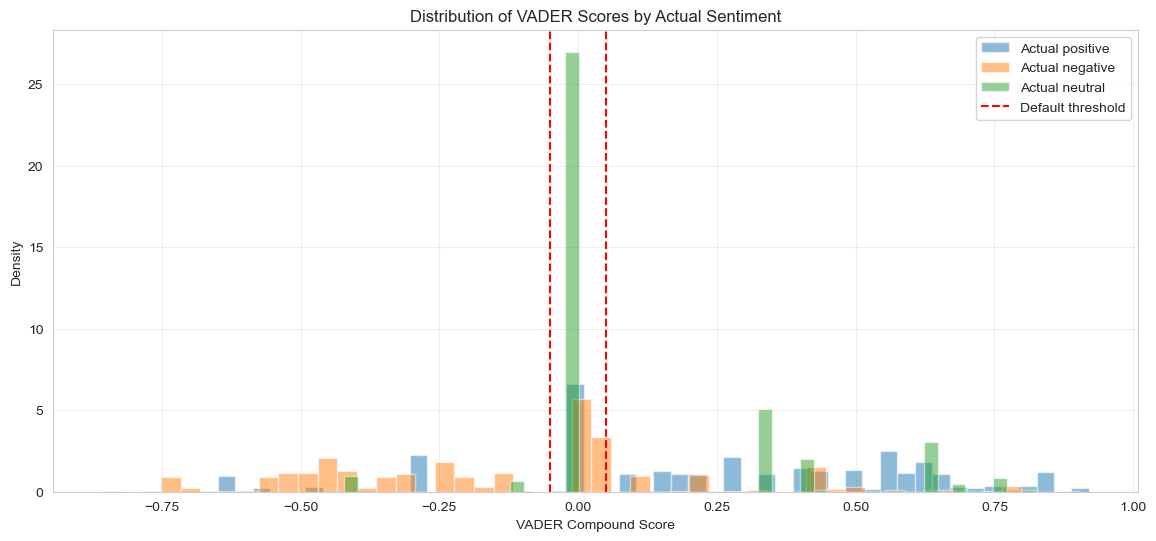

SCORE DISTRIBUTIONS:
Positive - Mean: 0.251, Median: 0.273
Neutral  - Mean: 0.127, Median: 0.000
Negative - Mean: -0.129, Median: -0.128

RECOMMENDED THRESHOLDS:
Negative threshold: 0.052 (was -0.05)
Positive threshold: 0.000 (was 0.05)


In [20]:
# Let's find optimal thresholds by examining the distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Plot compound score distribution by actual sentiment
fig, ax = plt.subplots(figsize=(14, 6))

for sentiment in ['positive', 'negative', 'neutral']:
    data = df[df['actual_sentiment'] == sentiment]['sentiment_compound']
    ax.hist(data, bins=50, alpha=0.5, label=f'Actual {sentiment}', density=True)

ax.axvline(x=-0.05, color='red', linestyle='--', label='Default threshold')
ax.axvline(x=0.05, color='red', linestyle='--')
ax.set_xlabel('VADER Compound Score')
ax.set_ylabel('Density')
ax.set_title('Distribution of VADER Scores by Actual Sentiment')
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal thresholds using the data
positive_scores = df[df['actual_sentiment'] == 'positive']['sentiment_compound']
negative_scores = df[df['actual_sentiment'] == 'negative']['sentiment_compound']
neutral_scores = df[df['actual_sentiment'] == 'neutral']['sentiment_compound']

print("SCORE DISTRIBUTIONS:")
print(f"Positive - Mean: {positive_scores.mean():.3f}, Median: {positive_scores.median():.3f}")
print(f"Neutral  - Mean: {neutral_scores.mean():.3f}, Median: {neutral_scores.median():.3f}")
print(f"Negative - Mean: {negative_scores.mean():.3f}, Median: {negative_scores.median():.3f}")
optimal_pos_threshold = positive_scores.quantile(0.25)
optimal_neg_threshold = negative_scores.quantile(0.75)

print(f"\nRECOMMENDED THRESHOLDS:")
print(f"Negative threshold: {optimal_neg_threshold:.3f} (was -0.05)")
print(f"Positive threshold: {optimal_pos_threshold:.3f} (was 0.05)")

As we can see, VADER is not very accurate or in line with the true sentiments. Eg: The negative sentiments are seen as more positive than neutral at times. One of the reasons for this might be that sports terminology can be different and we need to specify the VADER compound scores for them. This is the approach below. 

In [26]:
# SOLUTION 2: Add Sports-Specific Context to VADER (COMPLETE VERSION)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report

def classify_sentiment_improved(compound_score, pos_threshold=0.15, neg_threshold=-0.15):
    """
    Improved classification with adjusted thresholds
    """
    if compound_score >= pos_threshold:
        return 'positive'
    elif compound_score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

analyzer_custom = SentimentIntensityAnalyzer()

sports_positive = {
    'dominant': 3.5,
    'explosive': 3.2,
    'unstoppable': 3.5,
    'elite': 3.0,
    'championship': 2.5,
    'brilliant': 3.0,
    'lockdown': 2.8,
    'deserves': 2.0,
    'earned': 2.2,
    'impressive': 2.5,
    'outstanding': 3.0,
    'perfect': 3.2,
    'shutdown': 2.8,
    'clutch': 2.5,
}

sports_negative = {
    'exposed': -3.0,
    'struggling': -2.5,
    'overrated': -3.2,
    'bias': -2.5,
    'questionable': -2.0,
    'disappointing': -2.5,
    'weak': -2.3,
    'gashed': -2.8,
    'vulnerable': -2.0,
    'terrible': -3.0,
    'awful': -3.0,
    'pathetic': -3.2,
    'embarrassing': -3.0,
}

analyzer_custom.lexicon.update(sports_positive)
analyzer_custom.lexicon.update(sports_negative)

def get_custom_sentiment(text):
    if pd.isna(text) or text == "":
        return {'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
    return analyzer_custom.polarity_scores(text)

df['sentiment_scores_custom'] = df['text_clean'].apply(get_custom_sentiment)
df['sentiment_compound_custom'] = df['sentiment_scores_custom'].apply(lambda x: x['compound'])
df['sentiment_label_custom'] = df['sentiment_compound_custom'].apply(
    lambda x: classify_sentiment_improved(x, pos_threshold=0.15, neg_threshold=-0.15)
)

cm_custom = confusion_matrix(df['actual_sentiment'], df['sentiment_label_custom'], 
                             labels=['positive', 'neutral', 'negative'])
cm_custom_df = pd.DataFrame(cm_custom, 
                            columns=['Pred: Positive', 'Pred: Neutral', 'Pred: Negative'],
                            index=['Actual: Positive', 'Actual: Neutral', 'Actual: Negative'])

accuracy_custom = (df['sentiment_label_custom'] == df['actual_sentiment']).mean()
print(f"\nAccuracy: {accuracy_custom:.1%}")
print("Updated Matrix")
print(cm_custom_df)



Accuracy: 73.1%
Updated Matrix
                  Pred: Positive  Pred: Neutral  Pred: Negative
Actual: Positive            1094            143             114
Actual: Neutral              123            293              10
Actual: Negative             125            311             855


This demonstrates a significant improvement of ~14%. To experiment with the sentiment further, I have also decided to apply transformers below as an experimental method, specifically DistilBERT. 

## DistilBERT Experimentation

In [27]:
%pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [31]:
# APPLY BERT TO ALL TWEETS - OPTIMIZED VERSION

import time
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

total_tweets = len(df)
if 'sentiment_pipeline' not in globals():
    from transformers import pipeline
    model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=-1)

batch_size = 32
bert_results = []
total_batches = (len(df) // batch_size) + 1

start_time = time.time()
last_update_time = start_time

for i in range(0, len(df), batch_size):
    batch_texts = df.iloc[i:i+batch_size]['text_clean'].tolist()
    
    try:
        batch_predictions = sentiment_pipeline(
            batch_texts, 
            truncation=True, 
            max_length=512,
            batch_size=batch_size
        )
        for result in batch_predictions:
            label_lower = result['label'].lower()
            
            # Map labels (handling different model outputs)
            if 'positive' in label_lower or result['label'] == 'LABEL_2':
                label = 'positive'
                score = result['score']
            elif 'negative' in label_lower or result['label'] == 'LABEL_0':
                label = 'negative'
                score = -result['score']
            else:
                label = 'neutral'
                score = 0.0
            
            bert_results.append({
                'label': label,
                'score': score,
                'confidence': result['score']
            })
        
    except Exception as e:
        print("Error!")

# Add results to dataframe
df['bert_label'] = [r['label'] for r in bert_results]
df['bert_score'] = [r['score'] for r in bert_results]
df['bert_confidence'] = [r['confidence'] for r in bert_results]

cm_bert_full = confusion_matrix(df['actual_sentiment'], df['bert_label'], 
                                labels=['positive', 'neutral', 'negative'])
cm_bert_full_df = pd.DataFrame(cm_bert_full, 
                               columns=['Pred: Positive', 'Pred: Neutral', 'Pred: Negative'],
                               index=['Actual: Positive', 'Actual: Neutral', 'Actual: Negative'])

print("Confusion Matrix:")
print(cm_bert_full_df)

accuracy_bert_full = (df['bert_label'] == df['actual_sentiment']).mean()
print(f"Overall Accuracy: {accuracy_bert_full:.1%}")

improvement = (accuracy_bert_full - vader_accuracy_full) * 100
print(f"BERT Improvement: {improvement:+.1f}%")

summary = {
    'Total Tweets': len(df),
    'Processing Time': str(total_duration),
    'Overall BERT Accuracy': f"{accuracy_bert_full:.1%}",
    'VADER Accuracy': f"{vader_accuracy_full:.1%}",
    'Improvement': f"{improvement:+.1f} pp",
    'Mean Confidence': f"{df['bert_confidence'].mean():.2f}",
    'High Confidence (>0.9)': f"{len(high_conf):,} ({len(high_conf)/len(df)*100:.1f}%)",
    'Low Confidence (<0.6)': f"{len(low_conf):,} ({len(low_conf)/len(df)*100:.1f}%)",
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
summary_df.to_csv('bert_analysis_summary.csv', index=False)

print(summary_df.to_string(index=False))

Confusion Matrix:
                  Pred: Positive  Pred: Neutral  Pred: Negative
Actual: Positive            1070            188              93
Actual: Neutral               35            380              11
Actual: Negative              56            126            1109
Overall Accuracy: 83.4%
BERT Improvement: +10.3%
                Metric         Value
          Total Tweets          3068
       Processing Time       0:00:19
 Overall BERT Accuracy         83.4%
        VADER Accuracy         73.1%
           Improvement      +10.3 pp
       Mean Confidence          0.81
High Confidence (>0.9) 1,076 (35.1%)
 Low Confidence (<0.6)   381 (12.4%)


## Combination Approach – Better Accuracy

In [36]:
# Create ensemble score function to complement the label
def ensemble_score(row):
    """
    Create a hybrid confidence score
    """
    vader_score = row['sentiment_compound_custom']
    
    if 'bert_score' in row:
        bert_score = row['bert_score']
        bert_confidence = row['bert_confidence']
        
        # If BERT is confident, weight it more
        if bert_confidence > 0.8:
            return (0.7 * bert_score) + (0.3 * vader_score)
        else:
            return (0.5 * bert_score) + (0.5 * vader_score)
    else:
        return vader_score

df['sentiment_ensemble'] = df.apply(ensemble_sentiment, axis=1)
df['sentiment_ensemble_score'] = df.apply(ensemble_score, axis=1)
from sklearn.metrics import confusion_matrix, classification_report

cm_ensemble_full = confusion_matrix(df['actual_sentiment'], df['sentiment_ensemble'], 
                                    labels=['positive', 'neutral', 'negative'])
cm_ensemble_full_df = pd.DataFrame(cm_ensemble_full, 
                                   columns=['Pred: Positive', 'Pred: Neutral', 'Pred: Negative'],
                                   index=['Actual: Positive', 'Actual: Neutral', 'Actual: Negative'])
print("Confusion Matrix:")
print(cm_ensemble_full_df)

accuracy_ensemble_full = (df['sentiment_ensemble'] == df['actual_sentiment']).mean()
print(f"Ensemble Accuracy: {accuracy_ensemble_full:.1%}")

vader_acc = (df['sentiment_label_custom'] == df['actual_sentiment']).mean()
bert_acc = (df['bert_label'] == df['actual_sentiment']).mean()

print("Final Method Comparison")
comparison = pd.DataFrame({
    'Method': ['VADER (Custom)', 'BERT', 'Ensemble (Your Hybrid)'],
    'Accuracy': [vader_acc, bert_acc, accuracy_ensemble_full],
    'Improvement vs VADER': [
        0,
        (bert_acc - vader_acc) * 100,
        (accuracy_ensemble_full - vader_acc) * 100
    ]
})
print(comparison.to_string(index=False))

Confusion Matrix:
                  Pred: Positive  Pred: Neutral  Pred: Negative
Actual: Positive            1166             86              99
Actual: Neutral               70            343              13
Actual: Negative              97             45            1149
Ensemble Accuracy: 86.6%
Final Method Comparison
                Method  Accuracy  Improvement vs VADER
        VADER (Custom)  0.730769              0.000000
                  BERT  0.834094             10.332464
Ensemble (Your Hybrid)  0.866362             13.559322


## Time-based Sentiment Analysis

In [49]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

daily_sentiment = df.groupby(['date_only', 'team_searched']).agg({
    'sentiment_ensemble_score': ['mean', 'std', 'count']
}).reset_index()
daily_sentiment.columns = ['date', 'team', 'mean_sentiment', 'std_sentiment', 'tweet_count']

def get_positive_ratio(group):
    return (group['sentiment_ensemble'] == 'positive').sum() / len(group) if len(group) > 0 else 0
daily_positive_ratio = df.groupby(['date_only', 'team_searched']).apply(get_positive_ratio).reset_index()
daily_positive_ratio.columns = ['date', 'team', 'positive_ratio']

daily_sentiment = daily_sentiment.merge(daily_positive_ratio, on=['date', 'team'])

sentiment_shifts = []

for team in df['team_searched'].unique():
    team_df = df[df['team_searched'] == team]
    for game_round in team_df['current_round'].dropna().unique():
        round_df = team_df[team_df['current_round'] == game_round]
        pre_game_tweets = round_df[round_df['game_timing'] == 'pre_game_24hrs']
        if len(pre_game_tweets) > 0:
            pre_game_sentiment = pre_game_tweets['sentiment_ensemble_score'].mean()
            pre_pos_ratio = (pre_game_tweets['sentiment_ensemble'] == 'positive').sum() / len(pre_game_tweets)
            pre_neg_ratio = (pre_game_tweets['sentiment_ensemble'] == 'negative').sum() / len(pre_game_tweets)
        else:
            pre_game_sentiment = np.nan
            pre_pos_ratio = np.nan
            pre_neg_ratio = np.nan
        post_game_tweets = round_df[round_df['game_timing'] == 'post_game_24hrs']
        if len(post_game_tweets) == 0 and game_round == 'championship':
            post_game_tweets = round_df[round_df['game_timing'] == 'during_game']
        
        if len(post_game_tweets) > 0:
            post_game_sentiment = post_game_tweets['sentiment_ensemble_score'].mean()
            post_pos_ratio = (post_game_tweets['sentiment_ensemble'] == 'positive').sum() / len(post_game_tweets)
            post_neg_ratio = (post_game_tweets['sentiment_ensemble'] == 'negative').sum() / len(post_game_tweets)
        else:
            post_game_sentiment = np.nan
            post_pos_ratio = np.nan
            post_neg_ratio = np.nan
        if not pd.isna(pre_game_sentiment) and not pd.isna(post_game_sentiment):
            game_result = round_df['game_result'].iloc[0] if 'game_result' in round_df.columns else None
            opponent = round_df['opponent'].iloc[0] if 'opponent' in round_df.columns else 'Unknown'
            
            sentiment_shifts.append({
                'team': team,
                'round': game_round,
                'opponent': opponent,
                'result': game_result,
                'pre_game_sentiment': pre_game_sentiment,
                'post_game_sentiment': post_game_sentiment,
                'sentiment_shift': post_game_sentiment - pre_game_sentiment,
                'pre_positive_ratio': pre_pos_ratio,
                'post_positive_ratio': post_pos_ratio,
                'pre_negative_ratio': pre_neg_ratio,
                'post_negative_ratio': post_neg_ratio,
                'positive_ratio_change': post_pos_ratio - pre_pos_ratio,
                'negative_ratio_change': post_neg_ratio - pre_neg_ratio,
                'pre_game_tweets': len(pre_game_tweets),
                'post_game_tweets': len(post_game_tweets)
            })

shifts_df = pd.DataFrame(sentiment_shifts)

print(shifts_df['round'].value_counts().sort_index())

if len(shifts_df) > 0:
    wins = shifts_df[shifts_df['result'] == 'won']
    losses = shifts_df[shifts_df['result'] == 'lost']
    
    print(f"\nWINS (n={len(wins)}):")
    if len(wins) > 0:
        print(f"  Average sentiment shift: {wins['sentiment_shift'].mean():+.3f}")
        print(f"  Average positive ratio change: {wins['positive_ratio_change'].mean()*100:+.1f}%")
    
    print(f"\nLOSSES (n={len(losses)}):")
    if len(losses) > 0:
        print(f"  Average sentiment shift: {losses['sentiment_shift'].mean():+.3f}")
        print(f"  Average negative ratio change: {losses['negative_ratio_change'].mean()*100:+.1f}%")
    
    for round_name in ['first_round', 'quarterfinals', 'semifinals', 'championship']:
        round_data = shifts_df[shifts_df['round'] == round_name]
        if len(round_data) > 0:
            print(f"\n{round_name.upper().replace('_', ' ')}:")
            print(f"  Games: {len(round_data)}")
            print(f"  Average shift: {round_data['sentiment_shift'].mean():+.3f}")
            
            round_wins = round_data[round_data['result'] == 'won']
            round_losses = round_data[round_data['result'] == 'lost']
            
            if len(round_wins) > 0:
                print(f"  Wins - avg shift: {round_wins['sentiment_shift'].mean():+.3f}")
            if len(round_losses) > 0:
                print(f"  Losses - avg shift: {round_losses['sentiment_shift'].mean():+.3f}")

round
championship     2
first_round      8
quarterfinals    8
semifinals       4
Name: count, dtype: int64

WINS (n=11):
  Average sentiment shift: +0.379
  Average positive ratio change: +23.1%

LOSSES (n=11):
  Average sentiment shift: -0.685
  Average negative ratio change: +52.1%

FIRST ROUND:
  Games: 8
  Average shift: -0.133
  Wins - avg shift: +0.411
  Losses - avg shift: -0.677

QUARTERFINALS:
  Games: 8
  Average shift: -0.139
  Wins - avg shift: +0.319
  Losses - avg shift: -0.598

SEMIFINALS:
  Games: 4
  Average shift: -0.043
  Wins - avg shift: +0.657
  Losses - avg shift: -0.742

CHAMPIONSHIP:
  Games: 2
  Average shift: -0.509
  Wins - avg shift: -0.072
  Losses - avg shift: -0.946


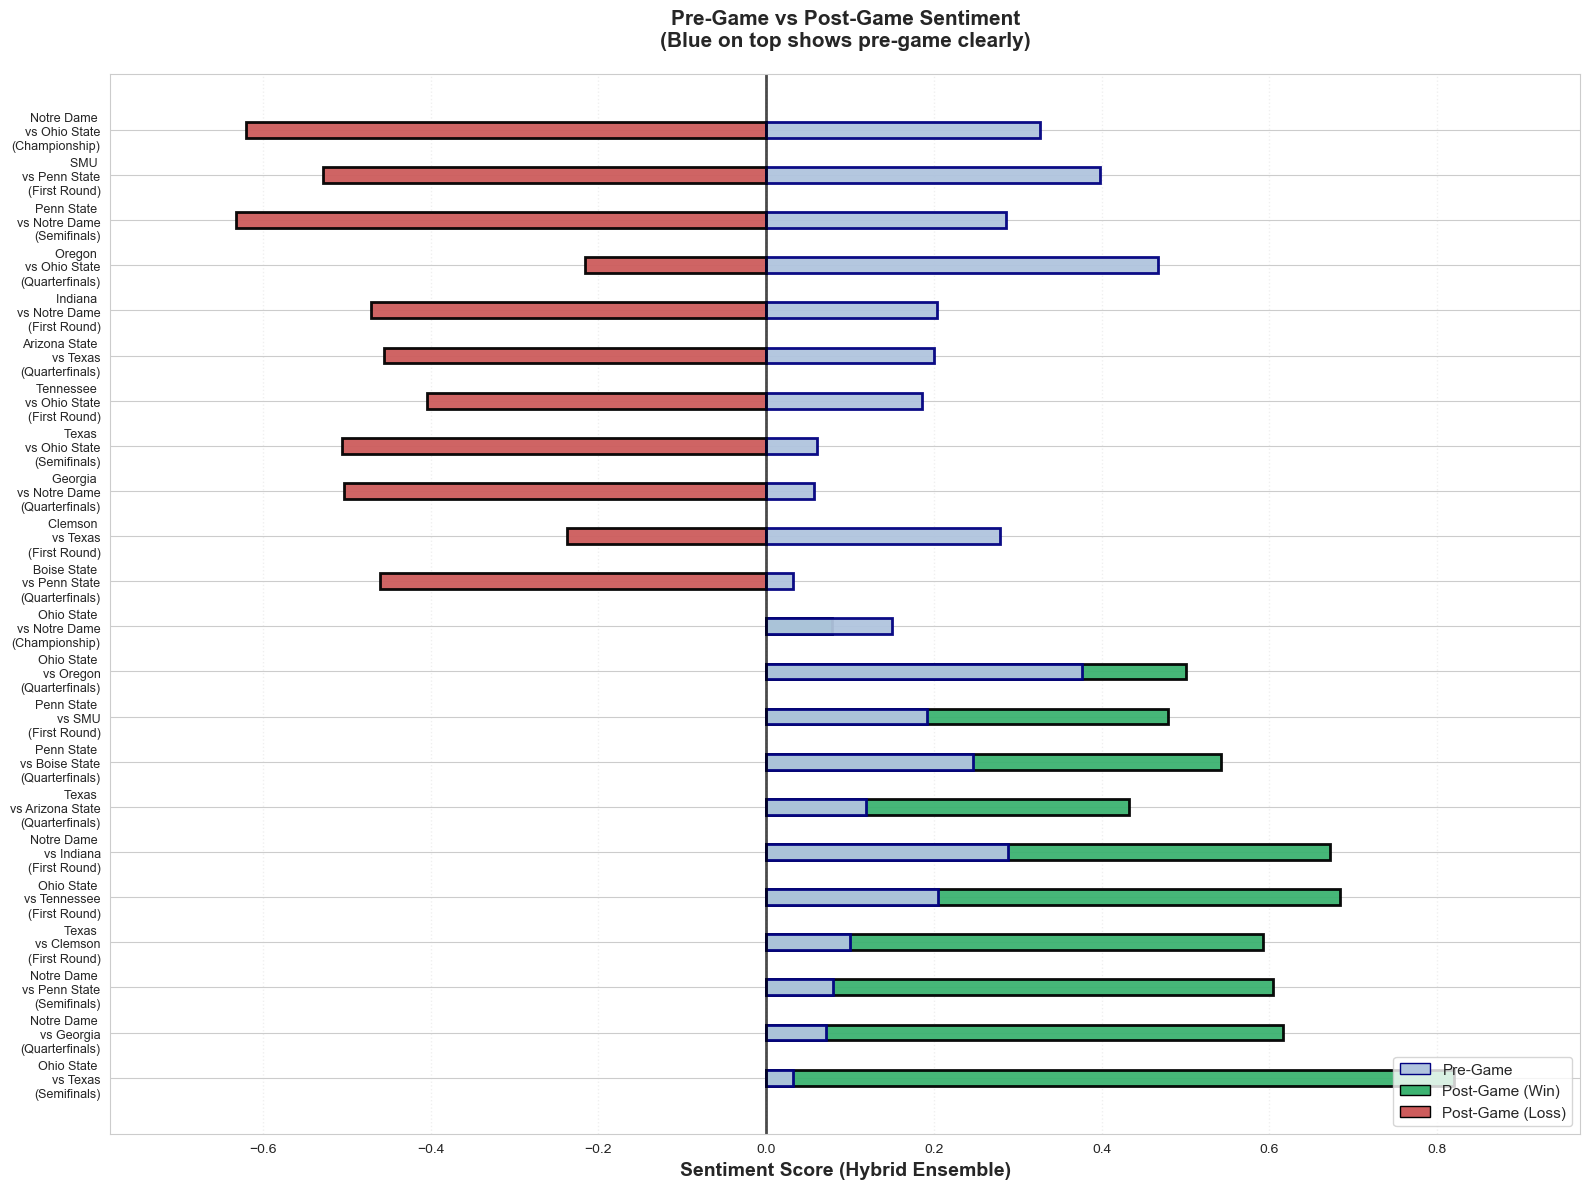

In [56]:
if len(shifts_df) > 0:
    shifts_sorted = shifts_df.sort_values('sentiment_shift', ascending=False)
    fig, ax = plt.subplots(figsize=(16, 12))
    n_games = len(shifts_sorted)
    y_pos = np.arange(n_games)
    labels = []
    for _, row in shifts_sorted.iterrows():
        label = f"{row['team']} \nvs {row['opponent']}\n({row['round'].replace('_', ' ').title()})"
        labels.append(label)
    
    width = 0.35
    
    # Plot POST-GAME FIRST (will be in back)
    colors = ['mediumseagreen' if r == 'won' else 'indianred' 
              for r in shifts_sorted['result']]
    bars2 = ax.barh(y_pos, shifts_sorted['post_game_sentiment'], 
                   width, label='Post-Game', alpha=0.95, 
                   color=colors, edgecolor='black', linewidth=2)
    
    # Plot PRE-GAME SECOND (will be on top)
    bars1 = ax.barh(y_pos, shifts_sorted['pre_game_sentiment'], 
                   width, label='Pre-Game', alpha=0.95, 
                   color='lightsteelblue', edgecolor='navy', linewidth=2)
        
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Sentiment Score (Hybrid Ensemble)', fontsize=14, fontweight='bold')
    ax.set_title('Pre-Game vs Post-Game Sentiment\n(Blue on top shows pre-game clearly)',
                fontsize=15, fontweight='bold', pad=20)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightsteelblue', edgecolor='navy', label='Pre-Game'),
        Patch(facecolor='mediumseagreen', edgecolor='black', label='Post-Game (Win)'),
        Patch(facecolor='indianred', edgecolor='black', label='Post-Game (Loss)')
    ]
    ax.legend(handles=legend_elements, fontsize=11, loc='lower right')
    ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=1)
    ax.set_xlim([min(shifts_sorted['pre_game_sentiment'].min(), 
                    shifts_sorted['post_game_sentiment'].min()) - 0.15,
                max(shifts_sorted['pre_game_sentiment'].max(), 
                    shifts_sorted['post_game_sentiment'].max()) + 0.15])
    plt.tight_layout()
    plt.savefig('sentiment_shifts_super_clean_hybrid.png', dpi=300, bbox_inches='tight')
    plt.show()

In [58]:
team_summary = df.groupby('team_searched').agg({
    'sentiment_ensemble_score': ['mean', 'median', 'std'],
    'tweet_id': 'count',
    'bert_confidence': 'mean'
}).round(3)

team_summary.columns = ['mean_score', 'median_score', 'std_score', 'tweet_count', 'avg_confidence']
label_dist = df.groupby(['team_searched', 'sentiment_ensemble']).size().unstack(fill_value=0)
label_dist['positive_pct'] = (label_dist['positive'] / label_dist.sum(axis=1) * 100).round(1)
label_dist['negative_pct'] = (label_dist['negative'] / label_dist.sum(axis=1) * 100).round(1)
label_dist['neutral_pct'] = (label_dist['neutral'] / label_dist.sum(axis=1) * 100).round(1)

team_summary = team_summary.join(label_dist[['positive', 'negative', 'neutral', 
                                              'positive_pct', 'negative_pct', 'neutral_pct']])
team_summary = team_summary.sort_values('mean_score', ascending=False)
team_summary['rank'] = range(1, len(team_summary) + 1)
team_summary = team_summary[[
    'rank', 'mean_score', 'median_score', 'std_score', 
    'positive_pct', 'neutral_pct', 'negative_pct',
    'positive', 'negative', 'neutral', 
    'tweet_count', 'avg_confidence'
]]

print(f"  Mean sentiment score: {df['sentiment_ensemble_score'].mean():.3f}")
print(f"  Median sentiment score: {df['sentiment_ensemble_score'].median():.3f}")
print(f"  Std deviation: {df['sentiment_ensemble_score'].std():.3f}")

sentiment_dist = df['sentiment_ensemble'].value_counts()
total = len(df)
for sentiment, count in sentiment_dist.items():
    pct = (count / total) * 100
    print(f"  {sentiment.capitalize():10s}: {count:,} tweets ({pct:.1f}%)")

print("Top 3 Positive Teams")
for i, (team, row) in enumerate(team_summary.head(3).iterrows(), 1):
    print(f"  {i}. {team:20s}: {row['mean_score']:+.3f} "
          f"({row['positive_pct']:.1f}% positive, {int(row['tweet_count']):,} tweets)")

print("Top 3 Negative Teams")
for i, (team, row) in enumerate(team_summary.tail(3).iterrows(), 1):
    print(f"  {i}. {team:20s}: {row['mean_score']:+.3f} "
          f"({row['negative_pct']:.1f}% negative, {int(row['tweet_count']):,} tweets)")

  Mean sentiment score: 0.055
  Median sentiment score: 0.000
  Std deviation: 0.610
  Positive  : 1,333 tweets (43.4%)
  Negative  : 1,261 tweets (41.1%)
  Neutral   : 474 tweets (15.4%)
Top 3 Positive Teams
  1. Ohio State          : +0.137 (50.2% positive, 305 tweets)
  2. Notre Dame          : +0.133 (50.5% positive, 319 tweets)
  3. Penn State          : +0.088 (46.1% positive, 306 tweets)
Top 3 Negative Teams
  1. Indiana             : +0.003 (37.5% negative, 234 tweets)
  2. Boise State         : -0.002 (39.9% negative, 219 tweets)
  3. Georgia             : -0.010 (39.9% negative, 247 tweets)
